In [1]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import re

In [3]:
import sys
sys.path.append('/links/groups/treutlein/USERS/zhisong_he/Tools/')
import scripts.py_util as util
import scripts.py_wknn as wknn

In [4]:
import sys
sys.path.append('../../ext/')
import codes.py_util as util
import codes.py_wknn as wknn
import codes.scarches_label_transfer as sclt

# Load BO atlas data and subset into telencephalic cells

In [5]:
adata_bo = sc.read_h5ad('../../data/phase3_final_0516/ZH_processed.h5ad')

In [120]:
adata_bo.obs.columns

Index(['assay_sc', 'assay_differentiation', 'assay_type_differentiation',
       'bio_sample', 'cell_line', 'cell_type', 'development_stage', 'disease',
       'ethnicity', 'gm',
       ...
       'final_region2', 'final_class', 'final_annot', 'pred_knn_scanvi_nnt',
       'final_nnt', 'final_annot_nnt', 'annot_level_1', 'annot_level_2',
       'annot_level_3', 'annot_level_4'],
      dtype='object', length=101)

In [121]:
adata_bo.obs.final_region2.value_counts()

Dorsal telencephalon     757626
Unspecific               369569
Ventral telencephalon    158506
Medulla                  136526
Cerebellum                94494
Thalamus                  75016
Hypothalamus              70103
Pons                      63328
Dorsal midbrain           30651
Ventral midbrain          14759
Name: final_region2, dtype: int64

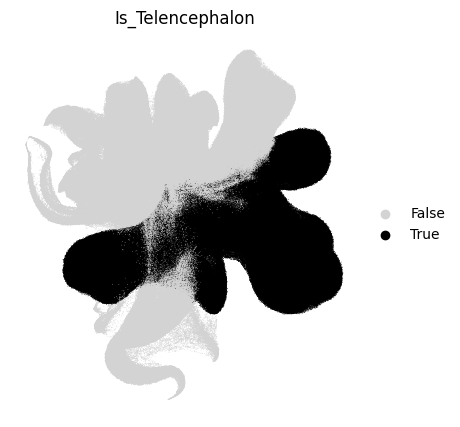

In [24]:
adata_bo.obs['Is_Telencephalon'] = ((adata_bo.obs['final_region2']=='Dorsal telencephalon') | (adata_bo.obs['final_region2']=='Ventral telencephalon')).astype('str')
from matplotlib.pyplot import rc_context
from matplotlib.colors import ListedColormap
from matplotlib import cm
with rc_context({'figure.figsize': (4.5, 5)}):
    sc.pl.embedding(adata_bo, basis='X_umap_scpoli', color=['Is_Telencephalon'], size=1, frameon=False, add_outline=False, wspace=0.5, ncols=2, palette=['lightgrey','black'])
del adata_bo.obs['Is_Telencephalon']

In [122]:
adata_telen = adata_bo[(adata_bo.obs['final_region2']=='Dorsal telencephalon') | (adata_bo.obs['final_region2']=='Ventral telencephalon'),:]
adata_telen.shape

(916132, 36842)

In [123]:
adata_telen.layers.keys()

KeysView(LayersView with keys: counts, counts_lengthnorm, lognorm)

In [124]:
adata_telen.layers['counts_raw'] = adata_telen.layers['counts'].copy()

In [126]:
from scipy import sparse

idx_i, idx_j, x = sparse.find(adata_telen.layers['counts_lengthnorm'])
x = np.round(x)
counts_int = sparse.csr_matrix((x, (idx_i, idx_j)), shape=adata_telen.shape)

adata_telen.layers['counts'] = counts_int
adata_telen.X = counts_int.copy()

#adata_telen.layers['counts'] = adata_telen.layers['counts_lengthnorm'].copy()
#adata_telen.X = adata_telen.layers['counts_lengthnorm'].copy()

In [127]:
adata_telen.write_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang.h5ad')

# Label transfer based on scArches to map to Wang et al. (scPoli)

## Data mapping

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
adata_telen = sc.read('../../data/phase3_final_0516/ZH_processed_telen_map2Wang.h5ad')

In [25]:
import os
if os.path.isfile('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad'):
    print('Loading the data with existed results...')
    adata_telen_raw = sc.read_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad')
else:
    print('Creating a raw copy...')
    adata_telen_raw = adata_telen.copy()

Loading the data with existed results...


In [7]:
adata_telen = sc.read_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang.h5ad')
adata_telen_raw = sc.read_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad')

In [42]:
import scvi
model = scvi.model.SCVI
model_path = '../../ext/models_Wang/scvi/model.pt'
model.prepare_query_anndata(adata_telen, model_path)

INFO     File ../../ext/models_Wang/scvi/model.pt/model.pt already downloaded                                      
INFO     Found 100.0% reference vars in query data.                                                                


In [43]:
import scarches

 captum (see https://github.com/pytorch/captum).


In [44]:
model = scarches.models.scPoli
model_path = '../../ext/models_Wang/scpoli'

In [45]:
adata_ref = sc.read_h5ad('../../ext/models_Wang/GEX_scpoli.h5ad')

In [46]:
vae = model.load(model_path, adata_ref)

AnnData object with n_obs × n_vars = 232328 × 3000
    obs: 'dataset', 'Group', 'sex', 'Region', 'class', 'subclass', 'type', 'Estimated_postconceptional_age_in_days', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'TSS.enrichment', 'SCR_score', 'individual', 'batch', '_scvi_batch', '_scvi_labels', 'conditions_combined'
    var: 'tmp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Group_colors', '_scvi_manager_uuid', '_scvi_uuid', 'class_colors', 'hvg', 'neighbors', 'subclass_colors', 'type_colors', 'umap'
    obsm: 'X_scanvi', 'X_scpoli', 'X_scvi', 'X_umap', 'X_umap_scanvi', 'X_umap_scvi', 'umap'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'
Embedding dictionary:
 	Num conditions: [28]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 3000 512 5
	Mean/Var Layer in/out: 512 20
Decoder Architecture:
	First Layer in, out and cond:  20 512 5
	Output L

In [47]:
adata_telen.obs['class'] = 'Unknown'
adata_telen.obs['subclass'] = 'Unknown'
adata_telen.obs['type'] = 'Unknown'

In [48]:
vae_q = model.load_query_data(
    adata=adata_telen,
    reference_model=vae,
    labeled_indices=[],
)

Embedding dictionary:
 	Num conditions: [356]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 3000 512 5
	Mean/Var Layer in/out: 512 20
Decoder Architecture:
	First Layer in, out and cond:  20 512 5
	Output Layer in/out:  512 3000 



In [ ]:
vae_q.train(
    n_epochs=50,
    pretraining_epochs=40,
    eta=10,
    batch_size = 8192
)

The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'Unknown'}
Therefore integer value of those labels is set to -1
The missing labels ar

In [52]:
vae_q.save("models_scarches_telen2Wang/scpoli")

In [57]:
adata_telen.obsm['X_scpoli_Wang'] = vae_q.get_latent(adata_telen, mean=True)

/cluster/project/treutlein/TOOLS/miniconda3/envs/env_scg/lib/python3.9/site-packages/scarches/models/scpoli/scpoli_model.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400412039/work/torch/csrc/utils/tensor_new.cpp:261.)
  c = torch.tensor(label_tensor, device=device).T


In [58]:
adata_telen_raw.obsm['X_scpoli_Wang'] = adata_telen.obsm['X_scpoli_Wang'].copy()

In [59]:
sc.pp.neighbors(adata_telen_raw, use_rep='X_scpoli_Wang')
sc.tl.umap(adata_telen_raw)
adata_telen_raw.obsm['X_umap_scpoli_Wang'] = adata_telen_raw.obsm['X_umap'].copy()

In [60]:
adata_telen_raw.write_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad')

In [61]:
adata_telen.write_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed_intermediate.h5ad')

## Label transfer with bipartite kNN, restrict to the neuronal subset (neural progenitors and neurons)

In [20]:
adata_ref = sc.read_h5ad('../../ext/models_Wang/GEX_scpoli.h5ad')

In [21]:
adata_ref.obs['subclass'].value_counts()

Glutamatergic neuron    109285
GABAergic neuron         35864
Oligodendrocyte          24613
Radial glia              16662
OPC                      12105
Astrocyte                11985
IPC-EN                    9058
Microglia                 6446
Vascular                  2572
IPC-Glia                  1551
Unknown                   1322
Cajal-Retzius cell         865
Name: subclass, dtype: int64

In [22]:
adata_ref = adata_ref[np.isin(adata_ref.obs['subclass'],['Glutamatergic neuron','GABAergic neuron','Radial glia','IPC-EN','Cajal-Retzius cell']),:]

In [23]:
wknn_scpoli_q2r = wknn.get_wknn(ref = adata_ref.obsm['X_scpoli'],
                                query = adata.obsm['X_scpoli_Wang'],
                                k = 50,
                                query2ref = True,
                                ref2query = False,
                                weighting_scheme = "jaccard_square")

Failed calling cuML. Falling back to neighborhood estimation using CPU with pynndescent
Failed calling cuML. Falling back to neighborhood estimation using CPU with pynndescent


In [24]:
df_labs_scpoli = { 'Group' : wknn.transfer_labels(adata_ref, adata, wknn_scpoli_q2r, label_key='Group'),
                   'class' : wknn.transfer_labels(adata_ref, adata, wknn_scpoli_q2r, label_key='class'),
                   'subclass' : wknn.transfer_labels(adata_ref, adata, wknn_scpoli_q2r, label_key='subclass'),
                   'type' : wknn.transfer_labels(adata_ref, adata, wknn_scpoli_q2r, label_key='type') }

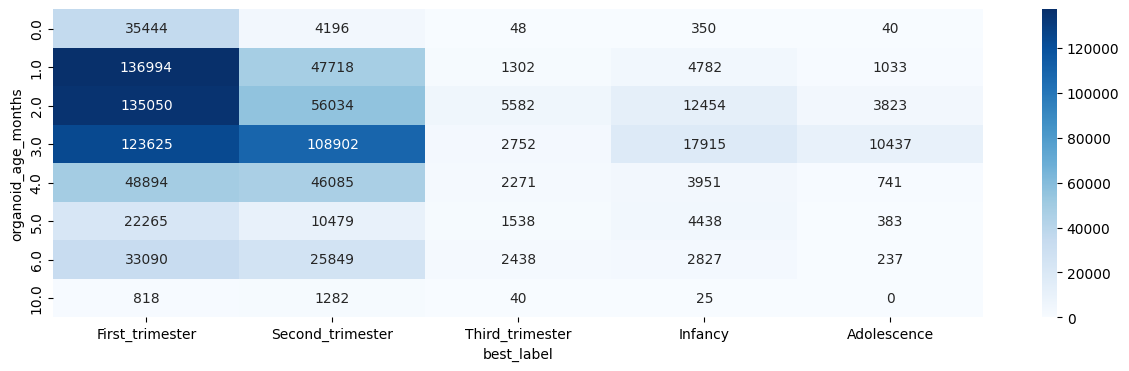

In [82]:
adata.obs['organoid_age_months'] = np.floor(adata.obs['organoid_age_days']/30)
freq_age_group = pd.crosstab(adata.obs['organoid_age_months'], df_labs_scpoli['Group']['best_label'])[['First_trimester','Second_trimester','Third_trimester','Infancy','Adolescence']]

import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(freq_age_group, annot=True, cmap='Blues', fmt='d')

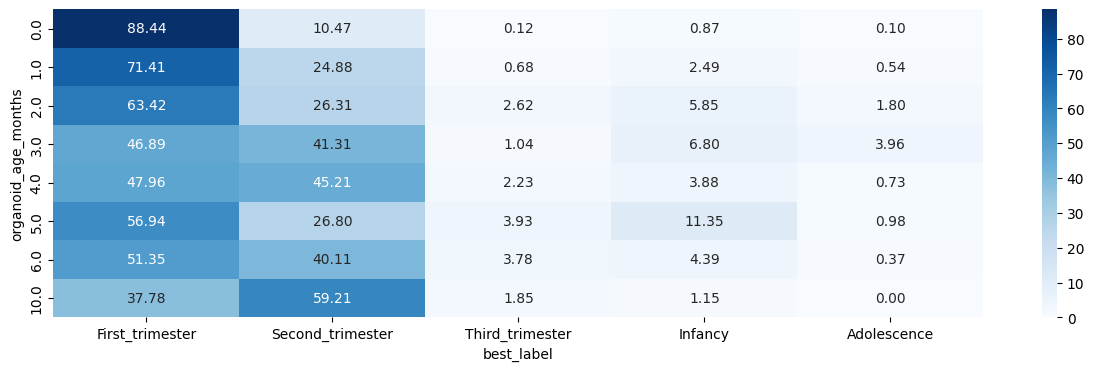

In [83]:
prop_age_group = freq_age_group.apply(lambda x: x/np.sum(x), axis=1) * 100
import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(prop_age_group, annot=True, cmap='Blues', fmt='.2f')

In [43]:
adata = adata_telen_raw

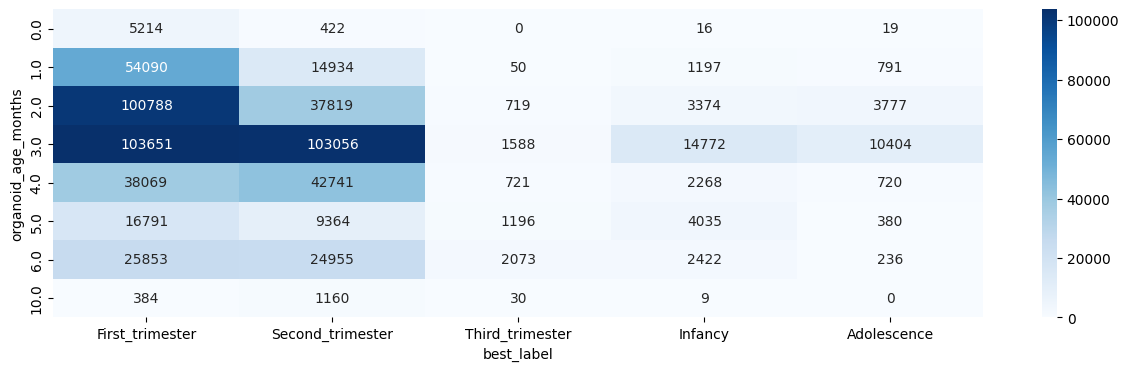

In [44]:
idx_neuron = adata.obs['annot_level_1']=='Neuron'
adata.obs['organoid_age_months'] = np.floor(adata.obs['organoid_age_days']/30)
freq_age_group = pd.crosstab(adata.obs['organoid_age_months'][idx_neuron], df_labs_scpoli['Group']['best_label'][idx_neuron])[['First_trimester','Second_trimester','Third_trimester','Infancy','Adolescence']]

import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(freq_age_group, annot=True, cmap='Blues', fmt='d')

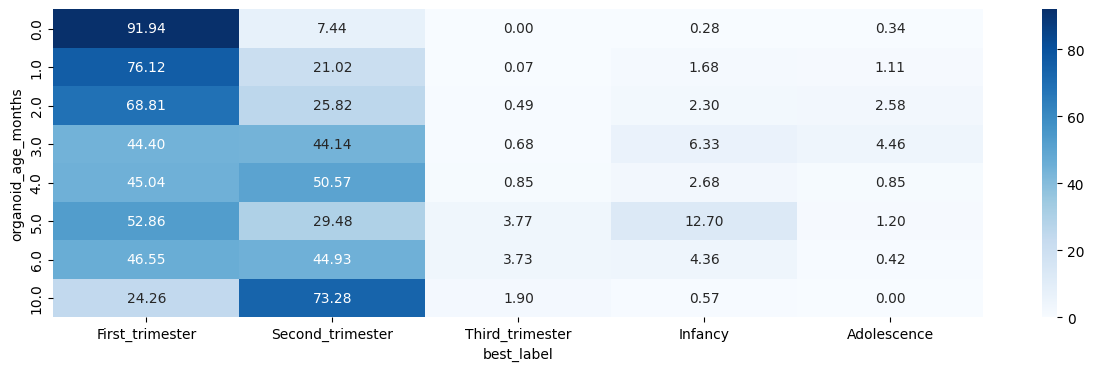

In [45]:
prop_age_group = freq_age_group.apply(lambda x: x/np.sum(x), axis=1) * 100
import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(prop_age_group, annot=True, cmap='Blues', fmt='.2f')

In [109]:
adata.obs['Group_Wang_scpoli_neuronal'] = df_labs_scpoli['Group']['best_label']
adata.obs['class_Wang_scpoli_neuronal'] = df_labs_scpoli['class']['best_label']
adata.obs['subclass_Wang_scpoli_neuronal'] = df_labs_scpoli['subclass']['best_label']
adata.obs['type_Wang_scpoli_neuronal'] = df_labs_scpoli['type']['best_label']

In [110]:
adata.write_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad')

# Label transfer based on similarities to Wang et al. clusters

In [6]:
adata_telen = sc.read('../../data/phase3_final_0516/ZH_processed_telen_map2Wang.h5ad')

In [7]:
import os
if os.path.isfile('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad'):
    print('Loading the data with existed results...')
    adata_telen_raw = sc.read_h5ad('../../data/phase3_final_0516/ZH_processed_telen_map2Wang-ed.h5ad')
else:
    print('Creating a raw copy...')
    adata_telen_raw = adata_telen.copy()

Loading the data with existed results...


In [8]:
adata_ref = sc.read_h5ad('../../ext/models_Wang/GEX_scpoli.h5ad')

In [9]:
adata_ref = adata_ref[np.isin(adata_ref.obs['subclass'],['Glutamatergic neuron','GABAergic neuron','Radial glia','IPC-EN','Cajal-Retzius cell']),:]

In [9]:
sc.pp.neighbors(adata_ref, use_rep='X_scpoli')
sc.tl.louvain(adata_ref, resolution = 2)

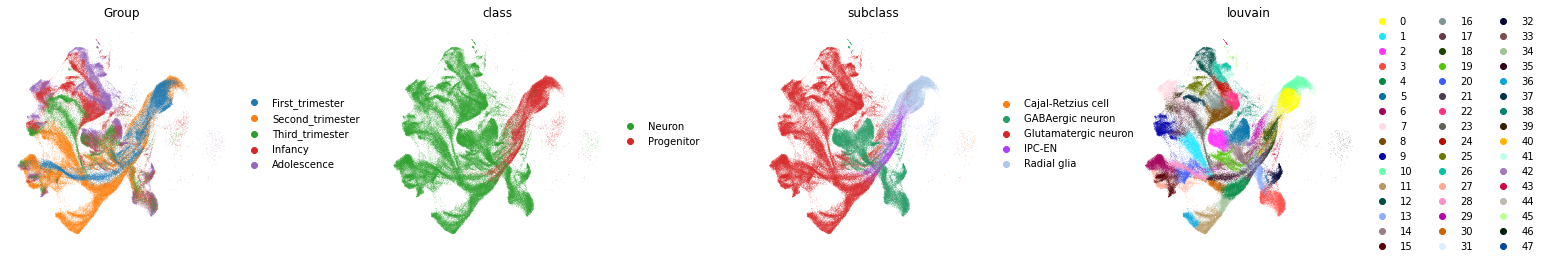

In [10]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(adata_ref, basis='X_umap', color=['Group','class','subclass','louvain'], size=0.6, frameon=False, add_outline=False, wspace=0.5)

In [10]:
adata_ref_stages = [ adata_ref[adata_ref.obs['Group'] == x,:] for x in adata_ref.obs['Group'].cat.categories ]

In [11]:
from tqdm import tqdm
for adata in tqdm(adata_ref_stages):
    sc.pp.neighbors(adata, use_rep='X_scpoli')
    sc.tl.louvain(adata, resolution = 5, key_added='louvain_res5_stage')

100%|██████████| 5/5 [01:14<00:00, 14.87s/it]


In [14]:
[ len(adata.obs['louvain_res5_stage'].cat.categories) for adata in adata_ref_stages ]

[52, 62, 58, 66, 61]

In [12]:
avg_cl_stages = list()
from tqdm import tqdm
for adata in tqdm(adata_ref_stages):
    avg_cl = list()
    #for x in tqdm_notebook(adata.obs['louvain_res10_stage'].cat.categories, leave=False):
    for x in adata.obs['louvain_res5_stage'].cat.categories:
        avg_cl.append(np.array(adata[adata.obs['louvain_res5_stage'] == x,:].raw.X.mean(axis=0)).flatten())
    avg_cl = np.array(avg_cl)
    avg_cl_stages.append(avg_cl)

100%|██████████| 5/5 [01:13<00:00, 14.73s/it]


In [24]:
adata_avg_cl_stages = [ anndata.AnnData(X=avg_cl_stages[i],
                                        obs=pd.concat([ pd.DataFrame({ 'Cluster' : adata_ref_stages[i].obs['louvain_res5_stage'].cat.categories,
                                                                      'Stage' : np.repeat(adata_ref.obs['Group'].cat.categories[i], avg_cl_stages[i].shape[0])},
                                                                     index = [adata_ref.obs['Group'].cat.categories[i]+'_'+str(x) for x in adata_ref_stages[i].obs['louvain_res5_stage'].cat.categories]),
                                                        util.summarize_dataframe(adata_ref_stages[i].obs[['class','subclass','type']], group=adata_ref_stages[i].obs['louvain_res5_stage']).set_index(adata_ref.obs['Group'].cat.categories[i]+'_'+str(x) for x in adata_ref_stages[i].obs['louvain_res5_stage'].cat.categories)
                                                      ], axis=1),
                                        var=adata_ref.raw.var.copy()) for i in range(len(adata_ref_stages)) ]
adata_avg_cl_stages = anndata.concat(adata_avg_cl_stages)
adata_avg_cl_stages.obs

,Cluster,Stage,class,subclass,type
First_trimester_0,0,First_trimester,Progenitor,IPC-EN,IPC-EN
First_trimester_1,1,First_trimester,Neuron,Glutamatergic neuron,EN-Newborn
First_trimester_2,2,First_trimester,Neuron,Glutamatergic neuron,EN-Non-IT-Immature
First_trimester_3,3,First_trimester,Progenitor,IPC-EN,IPC-EN
First_trimester_4,4,First_trimester,Progenitor,Radial glia,RG-vRG
...,...,...,...,...,...
Adolescence_56,56,Adolescence,Neuron,GABAergic neuron,IN-CGE-LAMP5
Adolescence_57,57,Adolescence,Neuron,GABAergic neuron,IN-CGE-VIP
Adolescence_58,58,Adolescence,Neuron,Glutamatergic neuron,EN-L5-ET
Adolescence_59,59,Adolescence,Neuron,GABAergic neuron,IN-MGE-SST


In [27]:
sc.pp.highly_variable_genes(adata_avg_cl_stages, flavor='cell_ranger', n_top_genes = 3000, batch_key = 'Stage')
adata_avg_cl_stages.raw = adata_avg_cl_stages
adata_avg_cl_stages = adata_avg_cl_stages[:,adata_avg_cl_stages.var.highly_variable]

In [28]:
adata_avg_cl_stages.obs['Stage'] = adata_avg_cl_stages.obs['Stage'].cat.reorder_categories(['First_trimester','Second_trimester','Third_trimester','Infancy','Adolescence'])

In [30]:
adata_avg_cl_stages.write_h5ad(
    '/links/groups/treutlein/USERS/zhisong_he/Work/public_datasets/Wang_Kriegstein_bioRxiv_2024_neocortex_development_scmultiome/analysis/GEX_scpoli_cluster_average.h5ad'
)

In [13]:
adata_avg_cl_stages = sc.read_h5ad(
    '/links/groups/treutlein/USERS/zhisong_he/Work/public_datasets/Wang_Kriegstein_bioRxiv_2024_neocortex_development_scmultiome/analysis/GEX_scpoli_cluster_average.h5ad'
)

In [31]:
adata_avg_cl_stages.obs['Stage'].value_counts(sort=False)

First_trimester     52
Second_trimester    62
Third_trimester     58
Infancy             66
Adolescence         61
Name: Stage, dtype: int64

In [32]:
shared_genes = np.intersect1d(adata_telen.var_names, adata_avg_cl_stages.var_names)
len(shared_genes)

2507

In [33]:
ranked_avg_cl_stages = util.rankMatrix_nonzero(adata_avg_cl_stages[:,shared_genes].X.T)
ranked_X = util.rankMatrix_nonzero(adata_telen[:,shared_genes].X.T)

In [34]:
cor2avg_spearman = util.corSparse(ranked_X, ranked_avg_cl_stages)

In [46]:
maxcorr_meta = adata_avg_cl_stages.obs[['Stage','class','subclass','type']].iloc[np.argmax(cor2avg_spearman, axis=1),:].set_axis(adata_telen.obs_names, axis=0)
maxcorr_meta.head()

,Stage,class,subclass,type
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_139,First_trimester,Neuron,GABAergic neuron,IN-dLGE-Immature
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_246,First_trimester,Progenitor,Radial glia,RG-vRG
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_382,First_trimester,Progenitor,Radial glia,RG-vRG
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_388,First_trimester,Progenitor,Radial glia,RG-vRG
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_623,First_trimester,Progenitor,Radial glia,RG-vRG


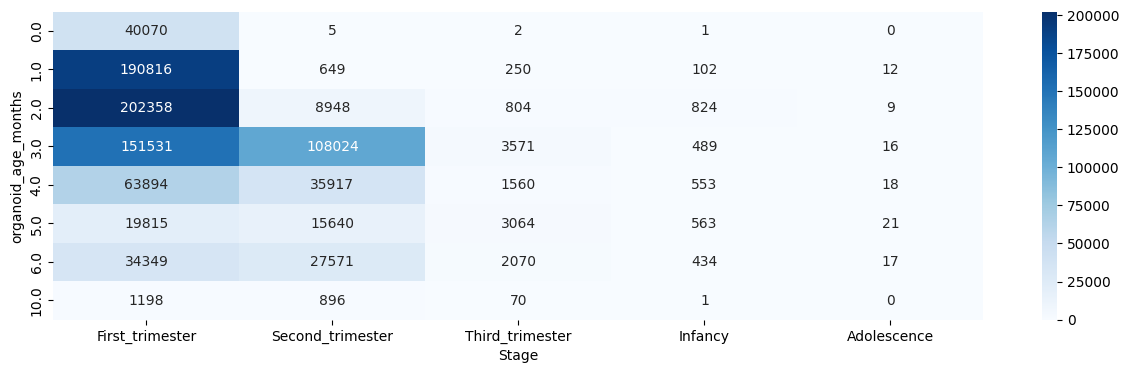

In [47]:
adata_telen.obs['organoid_age_months'] = np.floor(adata_telen.obs['organoid_age_days']/30)
freq_age_group = pd.crosstab(adata_telen.obs['organoid_age_months'], maxcorr_meta['Stage'])

import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(freq_age_group, annot=True, cmap='Blues', fmt='d')

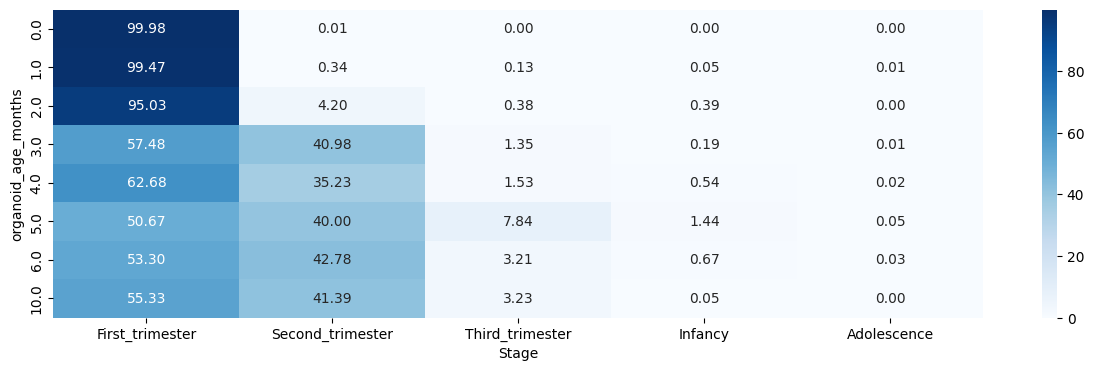

In [48]:
prop_age_group = freq_age_group.apply(lambda x: x/np.sum(x), axis=1) * 100
import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(prop_age_group, annot=True, cmap='Blues', fmt='.2f')

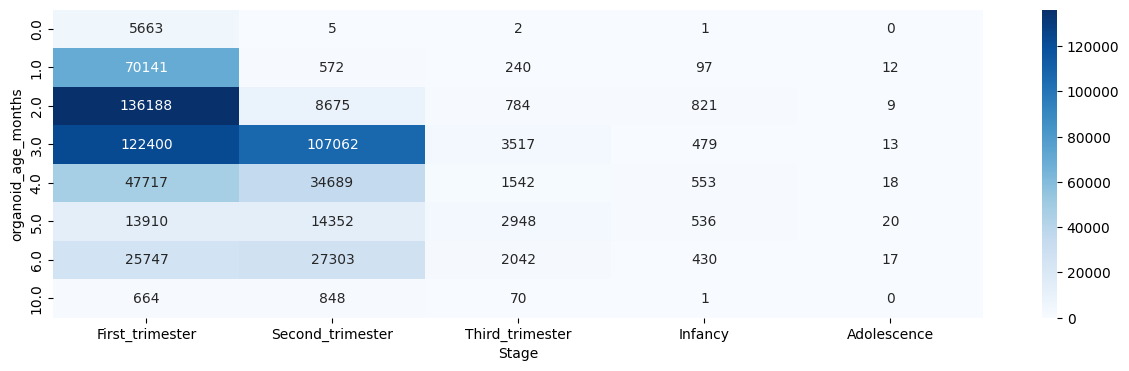

In [49]:
idx_neuron = adata_telen.obs['annot_level_1']=='Neuron'
freq_age_group = pd.crosstab(adata_telen.obs['organoid_age_months'][idx_neuron], maxcorr_meta['Stage'][idx_neuron])

import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(freq_age_group, annot=True, cmap='Blues', fmt='d')

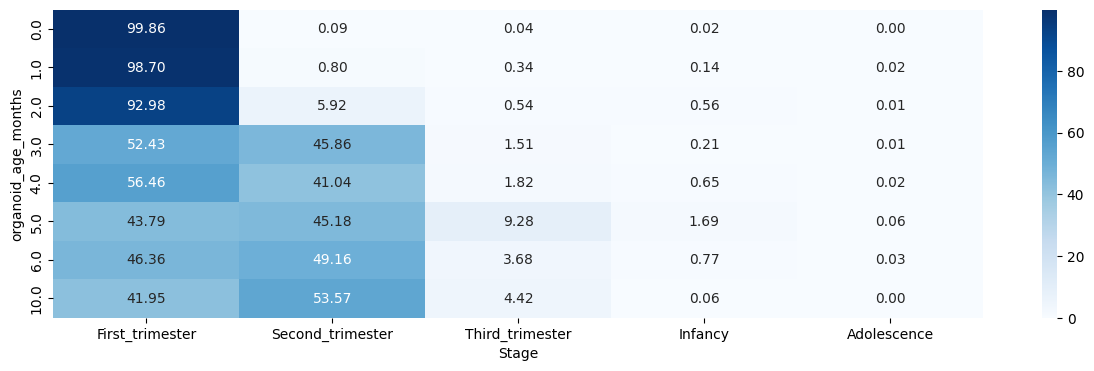

In [50]:
prop_age_group = freq_age_group.apply(lambda x: x/np.sum(x), axis=1) * 100
import seaborn as sns
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (15, 4)}):
    sns.heatmap(prop_age_group, annot=True, cmap='Blues', fmt='.2f')

In [54]:
adata_telen_raw.obs['Group_Wang_scpoli_neuronal_cl'] = maxcorr_meta['Stage']
adata_telen_raw.obs['class_Wang_scpoli_neuronal_cl'] = maxcorr_meta['class']
adata_telen_raw.obs['subclass_Wang_scpoli_neuronal_cl'] = maxcorr_meta['subclass']
adata_telen_raw.obs['type_Wang_scpoli_neuronal_cl'] = maxcorr_meta['type']
adata_telen_raw.obs.head()

,assay_sc,assay_differentiation,assay_type_differentiation,bio_sample,cell_line,cell_type,development_stage,disease,ethnicity,gm,...,subclass_Wang_neuronal_scpoli,type_Wang_neuronal_scpoli,Group_Wang_scpoli_neuronal_cl,Group_Wang_scpoli_neuronal,class_Wang_scpoli_neuronal,subclass_Wang_scpoli_neuronal,type_Wang_scpoli_neuronal,class_Wang_scpoli_neuronal_cl,subclass_Wang_scpoli_neuronal_cl,type_Wang_scpoli_neuronal_cl
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_139,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,custom_8858-1,unknown,Carnegie stage 18,unknown,unknown,unknown,...,GABAergic neuron,IN-CGE-SNCG,First_trimester,First_trimester,Neuron,GABAergic neuron,IN-CGE-SNCG,Neuron,GABAergic neuron,IN-dLGE-Immature
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_246,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,custom_8858-1,unknown,Carnegie stage 18,unknown,unknown,unknown,...,Radial glia,RG-vRG,First_trimester,First_trimester,Progenitor,Radial glia,RG-vRG,Progenitor,Radial glia,RG-vRG
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_382,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,custom_8858-1,unknown,Carnegie stage 18,unknown,unknown,unknown,...,Radial glia,RG-vRG,First_trimester,First_trimester,Progenitor,Radial glia,RG-vRG,Progenitor,Radial glia,RG-vRG
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_388,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,custom_8858-1,unknown,Carnegie stage 18,unknown,unknown,unknown,...,Radial glia,RG-vRG,First_trimester,First_trimester,Progenitor,Radial glia,RG-vRG,Progenitor,Radial glia,RG-vRG
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_623,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,custom_8858-1,unknown,Carnegie stage 18,unknown,unknown,unknown,...,Radial glia,RG-vRG,First_trimester,First_trimester,Progenitor,Radial glia,RG-vRG,Progenitor,Radial glia,RG-vRG


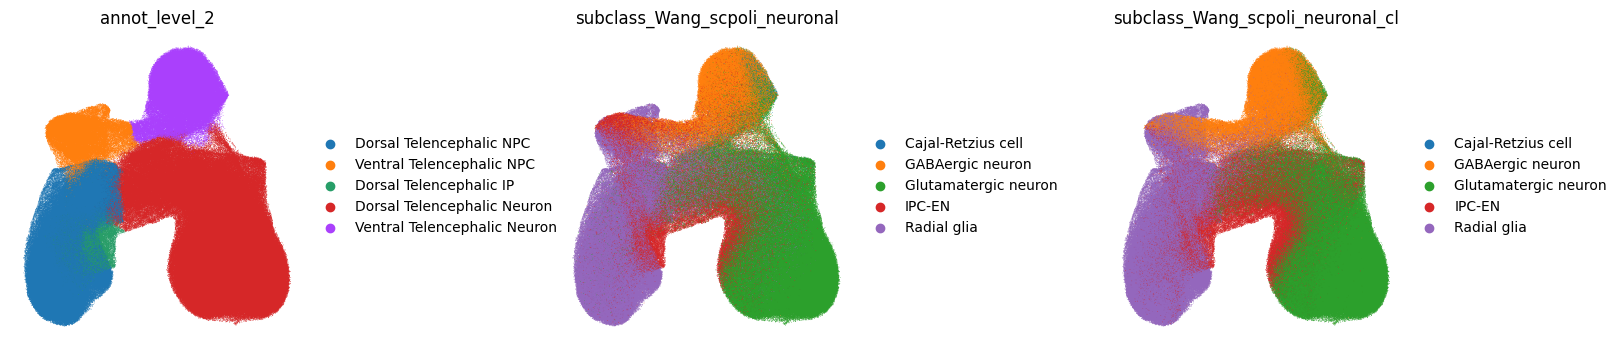

In [30]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.embedding(adata_telen_raw, basis='X_umap_scpoli_telen', color=['annot_level_2','subclass_Wang_scpoli_neuronal','subclass_Wang_scpoli_neuronal_cl'],
                    size=1, frameon=False, add_outline=False, wspace=0.7, ncols=3)

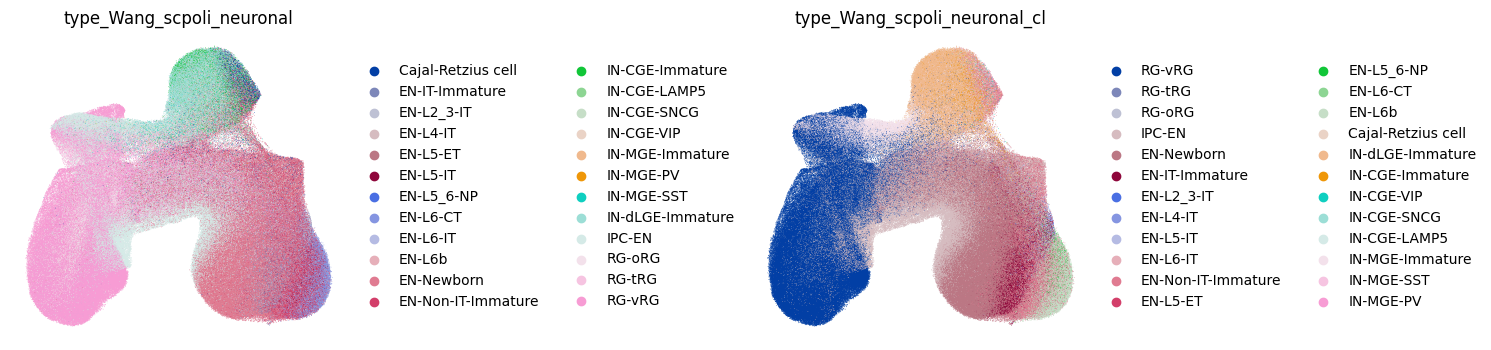

In [31]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.embedding(adata_telen_raw, basis='X_umap_scpoli_telen', color=['type_Wang_scpoli_neuronal','type_Wang_scpoli_neuronal_cl'],
                    size=1, frameon=False, add_outline=False, wspace=1, ncols=2)

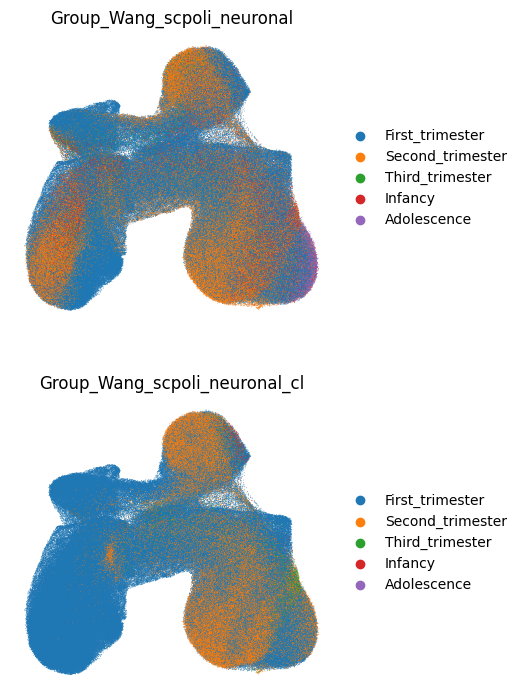

In [37]:
adata_telen_raw.obs['Group_Wang_scpoli_neuronal'] = adata_telen_raw.obs['Group_Wang_scpoli_neuronal'].cat.reorder_categories(adata_telen_raw.obs['Group_Wang_scpoli_neuronal_cl'].cat.categories)
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (3, 4)}):
    sc.pl.embedding(adata_telen_raw, basis='X_umap_scpoli_telen', color=['Group_Wang_scpoli_neuronal','Group_Wang_scpoli_neuronal_cl'],
                    size=1, frameon=False, add_outline=False, wspace=0.5, ncols=1)